# Autoregressive Models

In this practical, we'll go over the following topics:
- Autoregressive models and when to use them
- Implementing equivariances in Autoregressive GNNs
- Evaluating scientific AI models

But first, a short introduction on the dataset used for this practical.

![Boids gif](figures/boids.gif)

## Boids (by Craig Reynolds)

The Boids algorithm, developed by Craig Reynolds [2], aims to replicate the behavior of flocking birds. 

The simplest setting, used in this practical, follows three simple rules:

1. Separation: Each boid should steer away from crowding local flockmates (avoiding collisions)
2. Alignment: Each boid should steer towards the average heading of local flockmates
3. Cohesion: Each boid should steer towards the average position of local flockmates

With some parameter tuning, these rules allow for some surprisingly realistic behavior. A gif of one of the simulations is shown above.

### Implementation details

Our dataset consists of 1000 samples of Boids simulations. Each simulation has 25 Boids and continues for 1000 timesteps. The Boids fly around in a 2D grid of 1000 x 1000 units.

In our simulations, Boids steer away from eachother (Separation) if they are within 16 units of eachother. Boids steer towards the average heading/position of all (local) flockmates within 40 units.*
Finally, we use periodic boundary conditions; Boids cannot leave the screen, they re-enter on the other side (pacman style).

* We use Euclidean distance (with PBC) here to compute the distance between boids. For a more detailed explanation, visit [The minimum image convention](https://en.wikibooks.org/wiki/Molecular_Simulation/Periodic_Boundary_Conditions) section of the wikibooks page on PBC.

## Problem setting

Boids simulations feature complex interactions between multiple actors (nodes). The simulation can be chaotic and very sensitive to initial conditions. 


This makes it an interesting playground for the models/frameworks discussed in the course. In this practical, we will implement an AR model from scratch, then gradually introduce equivariances and training/evaluation methods.


In [1]:
import torch 
import torch_geometric
from torch_geometric.data import Data, DataLoader, InMemoryDataset
import numpy as np
import matplotlib.pyplot as plt
import os

C:\Users\runeg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\runeg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\runeg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while imp

## Data exploration

First let's look at the data structure, and some statistics.

In [2]:
trajectories = [np.load(f"../../data/boids/raw/{f}") for f in os.listdir("../../data/boids/raw") if f.endswith(".npy")]
print(len(trajectories))

26


In [3]:
print("Single trajectory shape:")
print(trajectories[0].shape)
print("The axes and their cardinalities; (Timesteps:1000, Boids:25, (Position X, Position Y, Velocity x, Velocity y):4)")

Single trajectory shape:
(1000, 25, 4)
The axes and their cardinalities; (Timesteps:1000, Boids:25, (Position X, Position Y, Velocity x, Velocity y):4)


In [4]:
# Print the mean, std, min and max of the boid positions, velocities
positions = np.array([t[:, :, :2] for t in trajectories])
velocities = np.array([t[:, :, 2:] for t in trajectories])

print("Position mean, std, min, max:")
# Round to 2 decimal places
print(round(np.mean(positions),2), round(np.std(positions),2), round(np.min(positions), 2), round(np.max(positions), 2))
print()
print("Velocity mean, std, min, max:")
# Round to 2 decimal places
print(round(np.mean(velocities),2), round(np.std(velocities),2), round(np.min(velocities), 2), round(np.max(velocities), 2))

Position mean, std, min, max:
500.32 290.61 0.0 1000.0

Velocity mean, std, min, max:
-0.35 2.96 -6.0 6.0


In [5]:
def plot_state(trajectory, timestep):
    fig, ax = plt.subplots()
    # Plot dots for the boids
    ax.scatter(trajectory[timestep, :, 0], trajectory[timestep, :, 1])
    # plot the boid velocities as arrows
    for i in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        ax.arrow(trajectory[timestep, i, 0], trajectory[timestep, i, 1], trajectory[timestep, i, 2]*5, trajectory[timestep, i, 3]*5)
    return ax

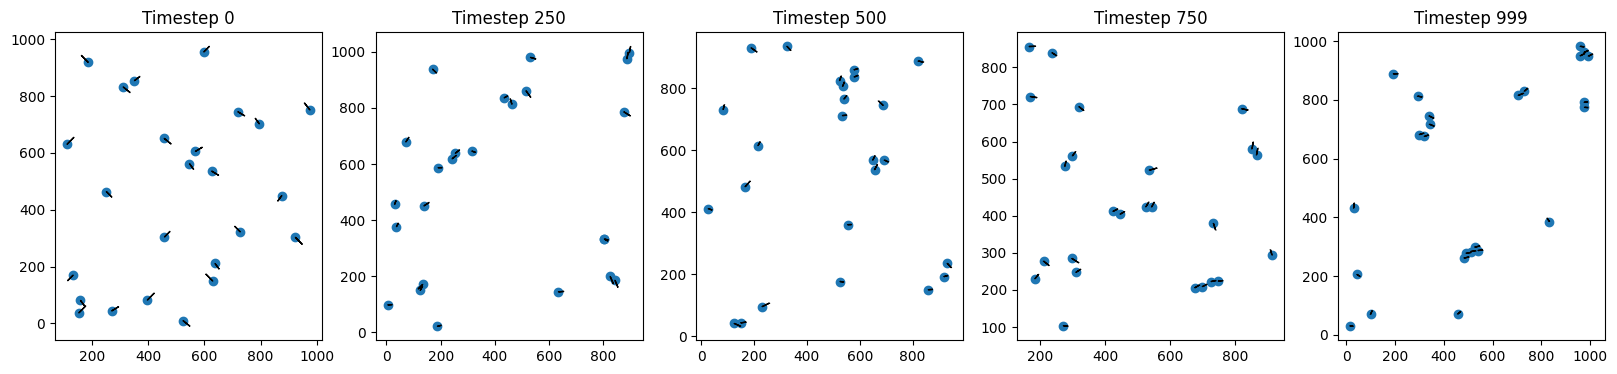

In [6]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = trajectories[0]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, t in enumerate([0, 250, 500, 750, 999]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # plot the boid velocities as arrows
    for j in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        axs[i].arrow(trajectory[t, j, 0], trajectory[t, j, 1], trajectory[t, j, 2]*5, trajectory[t, j, 3]*5)
plt.show()

In the plot above, you can see that after some warmup time, the boids start to form flocks. Flocking behavior is a form of inter-node communication, which we will come back to again later.

Thinking back to the Geometric Deep Learning framework, we can identify the following symmetries in the data:

- The boids are equivariant to permutations, ie it does not matter in which order we compute the update rules for the boids.
- Local flocks of boids are equivariant to translation, rotation and reflection. 

Following these symmetries, it makes sense to model the boids using a Graph Neural Network (GNN). Specifically, since we are dealing with inter-node communication, we will be implementing a Message Passing GNN here.

But first, we create a `torch_geometric` InMemoryDataset object, to model the data as a graph.

In [7]:
class AR_Boids_Dataset(InMemoryDataset):
    def __init__(self, raw_data_path, processed_data_path, root=None, transform=None, pre_transform=None, post_transform=None, solution_idx_range=(0, 25), timesteps=1000, processed_file_name="AR1_Boids.pt"):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        super(AR_Boids_Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [pfn for pfn in os.listdir(self.raw_data_path) if (self.solution_idx_range[0] <= int(pfn.split("_")[-1][:-4]) < self.solution_idx_range[1])]
    
    def download(self):
        pass
    
    def __len__(self):
        return (self.timesteps - 1) * (self.solution_idx_range[1] - self.solution_idx_range[0])

    def process(self):
        data_list = []
        for idx, raw_path in enumerate(self.raw_file_names):
            trajectory = np.load(self.raw_data_path + raw_path)

            if self.transform is not None:
                trajectory = self.transform(trajectory)

            for t in range(trajectory.shape[0] - 1):
                x = torch.tensor(trajectory[t], dtype=torch.float)
                y_temp = torch.tensor(trajectory[t+1], dtype=torch.float)
                # y_temp is (position x, position y, velocity x, velocity y) for the next timestep
                # However, we want delta position and delta velocity
                # Luckily, the delta poisition is just the velocity from the next timestep, and the delta velocity is the acceleration
                # So we can just take the last two elements of y to get the delta velocity
                # First we copy the last two columns of y to the first two columns of y
                y = y_temp.clone()
                y[:, :2] = y_temp[:, 2:]
                # Then we calculate the acceleration
                y[:, 2:] = y_temp[:, 2:] - x[:, 2:]    # (V_x ^ (t+1), V_y ^ (t+1), a_x, a_y)

                # fully connected graph
                edge_index = torch.tensor([[i, j] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.long).t().contiguous()
    
                if self.post_transform is not None:
                    data = self.post_transform(data)
                
                data = Data(x=x, y=y, edge_index=edge_index)
                data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_data_path+self.processed_file_name)

    def __getitem__(self, idx):
        return self.get(idx)
    
    def __repr__(self):
        return f'{self.__class__.__name__}({len(self)})'

In [8]:
train_dataset = AR_Boids_Dataset(raw_data_path="../../data/boids/raw/", processed_data_path="../../data/boids/processed/", root="../../data/boids/", solution_idx_range=(0, 15), timesteps=1000, processed_file_name="AR1_Boids.pt")
validation_dataset = AR_Boids_Dataset(raw_data_path="../../data/boids/raw/", processed_data_path="../../data/boids/processed/", root="../../data/boids/", solution_idx_range=(16, 25), timesteps=1000, processed_file_name="AR1_VAL_Boids.pt")

print(train_dataset)
print(validation_dataset)


data_0 = train_dataset[0]
print(data_0)
print(data_0.keys)
print("Pos x, Pos y, Vel x, Vel y")
print(data_0.x[0,:])

C:\Users\runeg\AppData\Local\Temp\ipykernel_31912\71744778.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


AR_Boids_Dataset(14985)
AR_Boids_Dataset(8991)
Data(x=[25, 4], edge_index=[2, 600], y=[25, 4])
<bound method BaseData.keys of Data(x=[25, 4], edge_index=[2, 600], y=[25, 4])>
Pos x, Pos y, Vel x, Vel y
tensor([719., 745.,   5.,  -3.])


In [9]:
ar_train_dataset=train_dataset
ar_val_dataset=validation_dataset

## Autoregressive Models
In general, when dealing with simulations spanning multiple timesteps, we can define the learning problem as follows.

Let $X^{0:T-1}$ denote the states spanning across timesteps $t=0$ through $t=T-1$. Given the initial state $X^0$, our goal is to accurately predict the future states $X^{1:T-1}$. In the probabilistic case, we want to learn a model with parameters $\theta$ for the probability distribution $P_\theta(X^{1:T-1}|X^0)$.*

In some systems, such as in the Boids setting, the next state X^{t+1} is only dependent on the current state X^t. Such systems are memoryless, and are often said to be _Markovian_. The Markov property allows us to rewrite the learning task to $P_\theta(X^{1:T-1}|X^0) = \prod_{t=0}^{T-2} P_\theta(X^{t+1} | X^t)$

Here, $P_\theta(X^{t+1} | X^t)$ is the _Autoregressive model_ - literally meaning it is used to autoregressively construct the full trajectory of the system. Note that this model is autoregressive in time; not space.

*: In this practical, we will not be building a probabilistic model. So instead of parameterizing a distribution, we learn a function $f_\theta: X^t \rarr X^{t+1}$.

### Autoregressive set model

Below, we create the simplest AR model for the Boids system; a fully connected GNN (essentially a set model).

Given a fully connected graph $X^t$, representing the Boids system at time $t$; it learns to predict the next state of the system $X^{t+1}$.

Note here that we use all features from the dataset as node features. This causes the model to not be equivariant to some group actions, that are relevant in the Boids setting.

---

Tick the equivariance(s) of this model:

- <input
      type="checkbox"
      id="eq0"
      name="perm"
      value="perm" />
    <label for="eq1">Permutational Equivariance</label>

- <input
      type="checkbox"
      id="eq1"
      name="space"
      value="space" />
    <label for="eq1">Space Translation Equivariance</label>

- <input
      type="checkbox"
      id="eq2"
      name="time"
      value="time" />
    <label for="eq2">Time Translation Equivariance</label>

- <input
      type="checkbox"
      id="eq3"
      name="rot"
      value="rot" />
    <label for="eq3">Rotation/Reflection Equivariance</label>

In [10]:
class AR_Set_Model(torch.nn.Module):
    def __init__(self, node_dim=4, emb_dim=16, out_dim=4):
        super(AR_Set_Model, self).__init__()
        self.node_embedding = torch.nn.Linear(node_dim, emb_dim)
        self.conv1 = torch_geometric.nn.GCNConv(emb_dim, emb_dim)
        self.conv2 = torch_geometric.nn.GCNConv(emb_dim, out_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.node_embedding(x)
        x = torch.nn.functional.relu(x)
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [11]:
class Trainer:
    def __init__(self, model, train_dataset, validation_dataset, batch_size=1, lr=0.0001, epochs=100, loss_fn=torch.nn.MSELoss(), model_name= "01-AR-Set-Model.pt"):
        """
        Simple Trainer class to train a PyTorch (geometric) model on a dataset.

        Args:
            model: PyTorch model to train
            train_dataset: PyTorch dataset to train on
            validation_dataset: PyTorch dataset to validate on
            batch_size: Batch size for training
            lr: Learning rate
            epochs: Number of epochs to train for
            loss_fn: Loss function to use
        """
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        self.train_loader = self.make_data_loader(self.train_dataset)
        self.validation_loader = self.make_data_loader(self.validation_dataset, shuffle=False)

    def make_data_loader(self, dataset, shuffle=True):
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train_loop(self):
        """
        Train loop for the model
        """
        best_model_loss = np.inf
        for epoch in range(self.epochs):
            # Train the model
            self.model.train()
            mean_train_loss = 0
            for i, data in enumerate(self.train_loader):
                data = self.train_dataset[i].to(self.device)
                self.optimizer.zero_grad()
                out = self.model(data)
                loss = self.loss_fn(out, data.y)
                loss.backward()
                self.optimizer.step()
                mean_train_loss += loss.item()
            mean_train_loss /= i
            
            # Validate the model
            self.model.eval()
            mean_val_loss = 0
            with torch.no_grad():
                for i, data in enumerate(self.validation_loader):
                    data = self.validation_dataset[i].to(self.device)
                    out = self.model(data)
                    loss = self.loss_fn(out, data.y)
                    mean_val_loss += loss.item()
                mean_val_loss /= i

            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(), f"../../models/{self.model_name}")
            
            print(f"Epoch {epoch}, Mean Train Loss: {mean_train_loss}, Mean Validation Loss: {mean_val_loss}")



In [46]:
model = AR_Set_Model(emb_dim=64)
trainer = Trainer(model, train_dataset, validation_dataset, batch_size=8, loss_fn=torch.nn.MSELoss(), epochs=100, model_name="01-AR-Set-Model.pt")
trainer.train_loop()

Using device: cuda


C:\Users\runeg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


KeyboardInterrupt: 

In [12]:
model = AR_Set_Model(emb_dim=64)
trainer = Trainer(model, train_dataset, validation_dataset, batch_size=8,
                  loss_fn=torch.nn.MSELoss(), epochs=100,
                  model_name="01-AR-Set-Model.pt")

Using device: cuda


C:\Users\runeg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Q1: Implementing rollout code

We have a working model now to predict $\hat{X}^{t+1}$ given $X^t$. However, we of course want to be able to generate trajectories longer than one step (ie for i steps: $\hat{X}^{t+1:t+i}$), given $X^t$.

We sometimes call this a `rollout` - essentially a multi-step prediction.

Q1: Complete the method below, which generates a rollout of `timesteps` steps, for a given model `model`, and dataset `dataset` *.

HINT: What should happen if the position $x_i, y_i$ of boid $i$ are predicted to move $dx_i, dy_i$, such that $x_i + dx_i > \text{width}$ or $y_i + dy_i > \text{height}$?

*: If you check the cell below the next cell, we already made a dataset for you that only contains initial positions :)

In [11]:
from torch_geometric.data import Data

def compute_ar_set_model_rollouts(model, dataset, timesteps=1000, device='cuda',
                                  mode="residual", width=1000, height=1000,
                                  vel_max=100.0):
    model = model.to(device)
    model.eval()

    first = dataset[0]
    N, F = first.x.shape
    S = len(dataset)
    rollouts = torch.empty((S, timesteps, N, F), device=device)

    idx = torch.arange(N)
    undirected = torch.combinations(idx, r=2, with_replacement=False).T
    edge_index = torch.cat([undirected, undirected.flip(0)], dim=1).to(device)

    with torch.no_grad():  # <<< disable grad tracking
        for s in range(S):
            g0 = dataset[s].to(device)
            state = g0.x.clone()
            rollouts[s, 0] = state

            for t in range(1, timesteps):
                data = Data(x=state, edge_index=edge_index).to(device)
                pred = model(data)

                if mode == "residual":
                    next_state = state + pred
                elif mode == "direct":
                    next_state = pred
                else:
                    raise ValueError("mode must be 'residual' or 'direct'")

                next_state[:, 0] = next_state[:, 0] % width
                next_state[:, 1] = next_state[:, 1] % height

                next_state[:, 2:] = torch.clamp(next_state[:, 2:], -vel_max, vel_max)

                if torch.isnan(next_state).any():
                    print(f"NaNs detected at rollout step {t}, seq {s} → replacing with 0")
                    next_state = torch.nan_to_num(next_state, nan=0.0)

                state = next_state
                rollouts[s, t] = state

    return rollouts




In [27]:
def keep_01(data):
    return data[0:2, :, :]

In [ ]:


initial_states_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../../data/boids/raw/", 
    processed_data_path="../../data/boids/processed/", 
    root="../../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=2, 
    processed_file_name="AR1_VAL_init.pt",
    transform=keep_01
    )

ar_set_model = AR_Set_Model(emb_dim=64)
ar_set_model.load_state_dict(torch.load("../../models/01-AR-Set-Model.pt"))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ar_set_model.to(device)
ar_set_model.eval()

ar_set_model_rollout = compute_ar_set_model_rollouts(ar_set_model, initial_states_validation_dataset, timesteps=1000, device=device)

C:\Users\runeg\AppData\Local\Temp\ipykernel_23932\71744778.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


In [12]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = ar_set_model_rollout[0].cpu().numpy()
fig, axs = plt.subplots(1, 6, figsize=(20, 4))
fig.suptitle("Boids with radius of effect")
radius = 40

for i, t in enumerate([0, 10,15, 20, 300, 700]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # Draw a red circle around each boid to indicate the radius
    for j in range(trajectory.shape[1]):
        circle = plt.Circle((trajectory[t, j, 0], trajectory[t, j, 1]), radius, color='r', fill=False)
        axs[i].add_artist(circle)
    # plot the boid velocities as arrows
        # NOTE: The arrows are made larger for effect
plt.show()

NameError: name 'ar_set_model_rollout' is not defined

We'll evaluate these rollouts later.

### Quick recap on equivariances

<img src="figures/boids-translational-equivariance.png" alt="drawing" width="250" style="background-color: white; padding: 50px;"/>
<img src="figures/boids-rotational-equivariance.png" alt="drawing" width="250" style="background-color: white; padding: 50px;"/>

The figures above show the equivariances of the Boids system. The system is equivariant to all E(n) transformations; translation,
rotation and reflection.*

Formally, we say a function $f: X \rarr Y$ is _equivariant_ to a group action or transformation $T: X \rarr X$ if there is an equivalent transformation $S: Y \rarr Y$ on the output space of the function such that

$f(T(x)) = S(f(x))$ for each $x \in X$

We won't go into the formal definitions of each equivariance, but if you're interested you can check out the [E(n) Equivariant Graph Neural Networks](https://arxiv.org/pdf/2102.09844) paper [3], the equivariant model is based on. 

*: Excluding time translation equivariance, which states that there is no dependence on the time of the system, only the state.

*: Also excluding permutational equivariance; the order of the nodes does not matter.

## Towards Equivariant AR-GNNs
The above model is **not** equivariant to translations in space! This is because we use absolute coordinates as _node features_, which creates a dependence on the absolute coordinate system. Instead, if we do not use the absolute positions as node features - and include the PBC distance as _edge features_ - the predictions will be space translation equivariant.

Let's implement this!

Before, we were not using the fact that boids only affect eachother within a certain radius, since we used a fully connected graph without edge weights.

Before blindly jumping into the new dataset code, let's investigate this behavior.

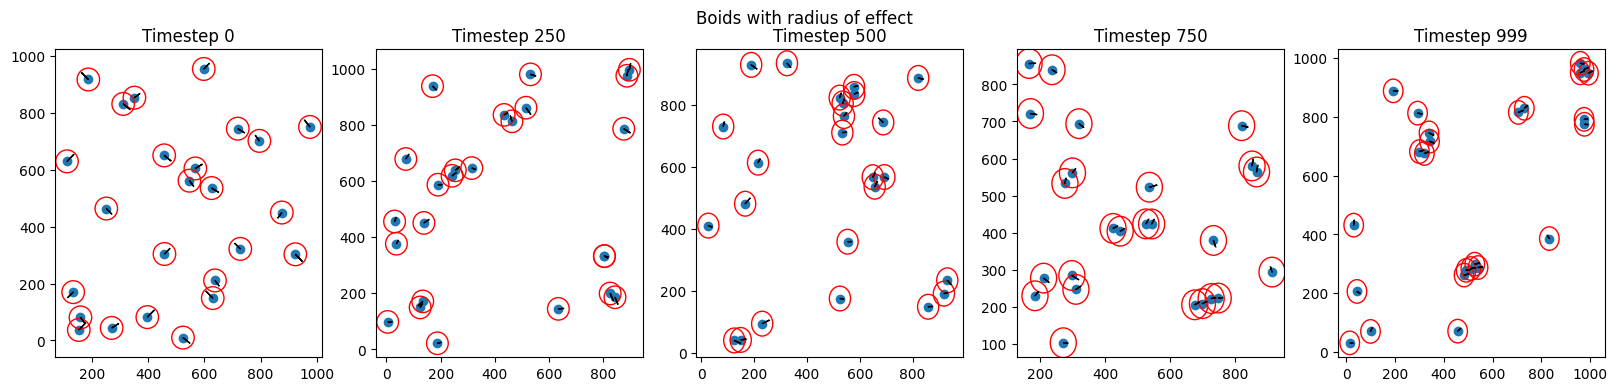

In [16]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = trajectories[0]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Boids with radius of effect")
radius = 40

for i, t in enumerate([0, 250, 500, 750, 999]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # Draw a red circle around each boid to indicate the radius
    for j in range(trajectory.shape[1]):
        circle = plt.Circle((trajectory[t, j, 0], trajectory[t, j, 1]), radius, color='r', fill=False)
        axs[i].add_artist(circle)
    # plot the boid velocities as arrows
    for j in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        axs[i].arrow(trajectory[t, j, 0], trajectory[t, j, 1], trajectory[t, j, 2]*5, trajectory[t, j, 3]*5)
plt.show()

## Q2 E(n) Equivariant Graph Neural Networks

In Satorras, Hoogeboom, Welling's paper [3] with the same name, they introduce a relatively simple model that is equivariant to E(n) transformations. 
You can check the official [implementation](https://github.com/vgsatorras/egnn).
implement the E(n)-Equivariant Graph Neural Networks (EGNN) model from scratch. 

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data

def scatter_add(src, index, dim=0, dim_size=None):
    out = torch.zeros((dim_size, src.size(-1)), device=src.device, dtype=src.dtype)
    return out.index_add(dim, index, src)
def mlp(channels, act=nn.SiLU, final_act=False, dropout=0.0):
    layers = []
    for i in range(len(channels) - 1):
        layers.append(nn.Linear(channels[i], channels[i+1]))
        if i < len(channels) - 2 or final_act:
            layers.append(act())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
    return nn.Sequential(*layers)

class EGNNLayer(nn.Module):
    """
    E(n)-Equivariant message passing layer.
    Inputs:
      x : (N, d) node coordinates (here d=2)
      h : (N, F) node features
      edge_index : (2, E) directed edges (i -> j)
      rel_disp : (E, d) relative displacement vectors (x_j - x_i) with periodic wrap (your edge_attr)
    """
    def __init__(self, in_features, hidden, coord_dim=2, edge_hidden=128, update_coords=True, dropout=0.0):
        super().__init__()
        self.coord_dim = coord_dim
        self.update_coords = update_coords

        self.phi_e = mlp([2 * in_features + 1, edge_hidden, edge_hidden], dropout=dropout)

        # phi_x: scalar to scale direction vector for coordinate update
        self.phi_x = mlp([edge_hidden, edge_hidden, 1], dropout=dropout)

        # phi_h: node update from (h_i, sum_j m_ij)
        self.phi_h = mlp([in_features + edge_hidden, hidden, hidden], dropout=dropout)

        # feature projection back to in_features (residual-style width keeping)
        self.h_proj = nn.Linear(hidden, in_features)

    def forward(self, x, h, edge_index, rel_disp):
        """
        x: (N, d), h: (N, F), edge_index: (2, E), rel_disp: (E, d)
        returns: x_out (N, d), h_out (N, F)
        """
        i, j = edge_index  
        # Use provided rel_disp = x_j - x_i (already wrapped), so ||x_j - x_i||^2 is invariant.
        r_ij = rel_disp  # (E, d)
        r2_ij = (r_ij ** 2).sum(dim=-1, keepdim=True)  # (E, 1)

        # Build edge inputs: [h_i, h_j, ||x_i - x_j||^2]
        e_in = torch.cat([h[i], h[j], r2_ij], dim=-1)  # (E, 2F+1)
        m_ij = self.phi_e(e_in)  # (E, H_e)

        # Coordinate update: x_j' = x_j + sum_i ( (x_j - x_i) * phi_x(m_ij) )
        if self.update_coords:
            w_ij = self.phi_x(m_ij)  # (E, 1)
            coord_msg = r_ij * w_ij  # (E, d)
            dx = scatter_add(coord_msg, j, dim=0, dim_size=x.size(0))  # sum over incoming to j
            x_out = x + dx
        else:
            x_out = x

        # Node (feature) update: h_j' = phi_h( h_j, sum_i m_ij )
        m_j = scatter_add(m_ij, j, dim=0, dim_size=h.size(0))  # (N, H_e)
        h_in = torch.cat([h, m_j], dim=-1)  # (N, F + H_e)
        h_hidden = self.phi_h(h_in)  # (N, H)
        h_delta = self.h_proj(h_hidden)  # (N, F)
        h_out = h + h_delta

        return x_out, h_out

class EGNN_Hybrid(nn.Module):
    """
    Hybrid EGNN:
      - Positions updated via equivariant EGNN layers.
      - Velocities predicted via velocity head.
      - Optional residual correction head for positions (uses only features h, so still E(n)-equivariant).
    """
    def __init__(self,
                 in_node_feats=2,
                 coord_dim=2,
                 hidden_dim=128,
                 n_layers=4,
                 edge_hidden=128,
                 dropout=0.0,
                 update_coords=True,
                 pos_residual=True):
        super().__init__()
        self.coord_dim = coord_dim
        self.in_node_feats = in_node_feats
        self.pos_residual = pos_residual

        # EGNN layers
        self.layers = nn.ModuleList([
            EGNNLayer(in_features=in_node_feats,
                      hidden=hidden_dim,
                      coord_dim=coord_dim,
                      edge_hidden=edge_hidden,
                      update_coords=update_coords,
                      dropout=dropout)
            for _ in range(n_layers)
        ])

        # Velocity head
        self.head_h = mlp([in_node_feats, hidden_dim, in_node_feats], dropout=dropout)
        self.head_vel = mlp([in_node_feats, hidden_dim, in_node_feats], dropout=dropout)

        # Small equivariant residual correction for positions
        if pos_residual:
            self.head_pos = mlp([in_node_feats, hidden_dim, coord_dim], dropout=dropout)

    def forward(self, data: Data):
        """
        data.x: (N, 4) = [pos(2), vel(2)]
        data.edge_index: (2, E)
        data.edge_attr: (E, 2) = relative displacement (x_j - x_i), optional
        """
        assert data.x.size(-1) == self.coord_dim + self.in_node_feats, \
            f"Expected state dim {self.coord_dim + self.in_node_feats}, got {data.x.size(-1)}"

        state = data.x
        x = state[:, :self.coord_dim]     # positions
        h = state[:, self.coord_dim:]     # velocities
        edge_index = data.edge_index
        rel_disp = getattr(data, 'edge_attr', None)

        if rel_disp is None:
            src, dst = edge_index
            rel_disp = x[dst] - x[src]

        # Pass through EGNN layers
        for layer in self.layers:
            x, h = layer(x, h, edge_index, rel_disp)

        # Velocity update
        vel_mid = self.head_h(h)
        vel_out = self.head_vel(vel_mid)

        # Position correction (optional, equivariant since only uses h)
        if self.pos_residual:
            pos_correction = self.head_pos(h)   # (N,2)
            x = x + pos_correction

        out = torch.cat([x, vel_out], dim=-1)  # (N,4)
        return out

In [14]:
from tqdm import trange

class Pushforward_Equivariant_Boids_Dataset(InMemoryDataset):
    def __init__(self, raw_data_path, processed_data_path, root=None,
                 transform=None, pre_transform=None, post_transform=None,
                 solution_idx_range=(0, 25), timesteps=1000,
                 processed_file_name="AR1_Boids_Equivariant.pt", L=1000):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        self.L = L
        super(Pushforward_Equivariant_Boids_Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [pfn for pfn in os.listdir(self.raw_data_path)
                if (self.solution_idx_range[0] <= int(pfn.split("_")[-1][:-4]) < self.solution_idx_range[1])]

    def download(self):
        pass

    # def __len__(self):
    #     return (self.timesteps - 1) * (self.solution_idx_range[1] - self.solution_idx_range[0])

    def process(self):
        max_forward_steps = 5
        data_list = []
        all_init_positions = []   
        vmax = 0.0
        for raw_path in self.raw_file_names:
            trajectory = np.load(os.path.join(self.raw_data_path, raw_path))  
            vels = trajectory[:, :, 2:]  
            vmax = max(vmax, np.abs(vels).max())
        if vmax == 0:
            vmax = 1.0

        print(f"[Normalization] Using L={self.L}, vmax={vmax:.4f}")

        for raw_path in self.raw_file_names:
            trajectory = np.load(os.path.join(self.raw_data_path, raw_path))

            init_pos = torch.tensor(trajectory[0, :, :2], dtype=torch.float)  
            all_init_positions.append(init_pos)

            for t in range(trajectory.shape[0] - max_forward_steps):
                pos_t = torch.tensor(trajectory[t, :, :2], dtype=torch.float) / self.L
                vel_t = torch.tensor(trajectory[t, :, 2:], dtype=torch.float) / vmax
                x = torch.cat([pos_t, vel_t], dim=-1) 

                y_sequence = []
                for step in range(max_forward_steps):

                    pos_next = torch.tensor(trajectory[t+1 + step, :, :2], dtype=torch.float) / self.L
                    vel_next = torch.tensor(trajectory[t+1 + step, :, 2:], dtype=torch.float) / vmax
                    y_sequence.append(torch.cat([pos_next, vel_next], dim=-1))

                y_tensor_3d = torch.stack(y_sequence, dim=0)  # (T, N, F)
                y = y_tensor_3d.permute(1, 0, 2).reshape(x.shape[0], -1)  # (N, T*F)


                N = pos_t.shape[0]
                edge_index = torch.combinations(torch.arange(N), r=2, with_replacement=False).T
                edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
                senders, receivers = edge_index

                rel_disp = pos_t[receivers] - pos_t[senders]
                rel_disp = rel_disp - torch.round(rel_disp)
                edge_attr = rel_disp

                data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
                data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

        all_init_positions = torch.stack(all_init_positions)   
        torch.save(all_init_positions, os.path.join(self.processed_data_path,
                                                    "positions_" + self.processed_file_name))
        print(f"Saved initial positions: {all_init_positions.shape}")
        
    def __getitem__(self, idx):
        return self.get(idx)
    
    def __repr__(self):
        return f'{self.__class__.__name__}({len(self)})'

In [15]:
pushforward_equivariant_train_dataset2 = Pushforward_Equivariant_Boids_Dataset(
    raw_data_path="../../data/boids/raw/", 
    processed_data_path="../../data/boids/processed/", 
    root="../../data/boids/", 
    solution_idx_range=(0, 15), 
    timesteps=1000, 
    processed_file_name="AR1_Boids_Equivariant1991.pt"
    )

pushforward_equivariant_validation_dataset2 = Pushforward_Equivariant_Boids_Dataset(
    raw_data_path="../../data/boids/raw/", 
    processed_data_path="../../data/boids/processed/", 
    root="../../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=1000, 
    processed_file_name="AR1_VAL_Boids_Equivariant1991.pt"
    )

In [113]:

import torch
from torch_geometric.data import Data

@torch.no_grad()
def model2_rollouts(model, dataset, positions_dataset, timesteps=1000, device='cuda',
                    mode="residual", width=1000, height=1000,
                    dataset_stride=None, assume_normalized=False):
    """
    Rollout for TranslationalEquivariantModel:
      - x = [pos, vel] in normalized space (pos in [0,1], vel ~ [-1,1])
      - edge_attr = relative displacement (PBC) in normalized units
    positions_dataset: (S, N, 2) absolute start positions; normalized here if needed.
    """

    model = model.to(device)
    model.eval()

    S = positions_dataset.shape[0]              # number of sequences
    N, F = dataset[0].x.shape                   # nodes, features
    if dataset_stride is None:
        dataset_stride = max(1, len(dataset) // S)

    rollouts = torch.empty((S, timesteps, N, F), device=device)

    # --- normalize positions ---
    pos0_abs = positions_dataset.to(device).float()   
    if pos0_abs.max() > 1.5:  
        pos0 = torch.stack([pos0_abs[..., 0] / width,
                            pos0_abs[..., 1] / height], dim=-1)
    else:
        pos0 = pos0_abs.clone()

    # --- initial velocities ---
    first_graphs = [dataset[s * dataset_stride] for s in range(S)]
    vel0 = torch.stack([g.x[:, 2:] for g in first_graphs], dim=0).to(device) 

    # normalize velocities to match model’s output scale
    if not assume_normalized:
        vel_scale = vel0.abs().max().clamp(min=1.0)   # avoid div by 0
        vel0 = vel0 / vel_scale
    else:
        vel_scale = 1.0

    # --- initial state ---
    state = torch.cat([pos0, vel0], dim=-1)  
    rollouts[:, 0] = state

    # --- edge_index setup ---
    idx = torch.arange(N, device=device)
    undirected = torch.combinations(idx, r=2, with_replacement=False).T
    edge_index = torch.cat([undirected, undirected.flip(0)], dim=1)  
    E = edge_index.shape[1]

    # --- rollout ---
    for t in range(1, timesteps):
        pos = state[..., :2]  

        send, recv = edge_index
        rel = pos[:, recv] - pos[:, send]   
        rel = rel - torch.round(rel)

        edge_index_exp = edge_index.unsqueeze(0).expand(S, -1, -1)      
        node_offsets = (torch.arange(S, device=device) * N).view(S, 1, 1) 
        edge_index_b = (edge_index_exp + node_offsets).reshape(2, -1)   

        x_b = state.reshape(S * N, F)        
        e_b = rel.reshape(S * E, 2)          

        data = Data(x=x_b, edge_index=edge_index_b, edge_attr=e_b).to(device)
        pred = model(data).view(S, N, F)

        next_state = state + pred if mode == "residual" else pred

        # wrap pos into [0,1]
        next_pos = next_state[..., :2] % 1.0
        # clamp velocity
        next_vel = torch.clamp(next_state[..., 2:], -2.0, 2.0)

        state = torch.cat([next_pos, next_vel], dim=-1)
        rollouts[:, t] = state

    return rollouts, vel_scale


## Q3 Push-forward training

Implement the push-forward training mechanism for the AR-Set-Model and the EGNN developed in Q2

### Push-forward for AR_Set_model

### Push-forward for EGNN

In [17]:
def _pushforward_schedule(epoch, max_forward_steps=5):
    if epoch < 20:
        return 1
    elif epoch < 30:
        return 2
    elif epoch < 50:
        return 3
    else:
        return max_forward_steps
    

class Trainer2:
    def __init__(self, model, train_dataset, validation_dataset, batch_size=1, lr=0.0001, epochs=100, loss_fn=torch.nn.MSELoss(), model_name= "01-EQ-Model.pt"):
        """
        Simple Trainer class to train a PyTorch (geometric) model on a dataset.

        Args:
            model: PyTorch model to train
            train_dataset: PyTorch dataset to train on
            validation_dataset: PyTorch dataset to validate on
            batch_size: Batch size for training
            lr: Learning rate
            epochs: Number of epochs to train for
            loss_fn: Loss function to use
        """
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        self.train_loader = self.make_data_loader(self.train_dataset)
        self.validation_loader = self.make_data_loader(self.validation_dataset, shuffle=False)

    def make_data_loader(self, dataset, shuffle=True):
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
    
    def train_loop_pushforward(self, L=1000, max_forward_steps=5):
        best_model_loss = np.inf

        for epoch in range(self.epochs):
            self.model.train()
            forward_steps = _pushforward_schedule(epoch, max_forward_steps)
            mean_train_loss = 0

            for data in self.train_loader:
                data = data.to(self.device)
                edge_attr = getattr(data, "edge_attr", None)
                self.optimizer.zero_grad()

                current_state = data.x.clone()
                batch_loss = 0
                ground_truth_ys = data.y
                num_features = 4

                for t in range(forward_steps):

                    # Pass coordinates and velocity as node features
                    out = self.model(Data(x=current_state,edge_index=data.edge_index, edge_attr=edge_attr))

                    # Compute loss
                    start_idx = t * num_features
                    end_idx = (t + 1) * num_features
                    true_y_at_step_t = ground_truth_ys[:, start_idx:end_idx]
                    batch_loss += self.loss_fn(out, true_y_at_step_t)

                    # Update state safely (out-of-place)
                    #TODO we do not do that anymore
                    new_coords = out[:, :2]      # apply PBC
                    new_velocity = out[:, 2:]
                    current_state = torch.cat([new_coords, new_velocity], dim=1)

                batch_loss.backward()
                self.optimizer.step()
                mean_train_loss += batch_loss.item()

            mean_train_loss /= len(self.train_loader)

            # Validation
            self.model.eval()
            mean_val_loss = 0
            with torch.no_grad():
                for data in self.validation_loader:
                    data = data.to(self.device)
                    edge_attr = getattr(data, "edge_attr", None)
                    current_state = data.x.clone()
                    ground_truth_ys = data.y
                    batch_val_loss = 0

                    for t in range(forward_steps):

                        out = self.model(Data(x=current_state, edge_index=data.edge_index, edge_attr=data.edge_attr))

                        start_idx = t * num_features
                        end_idx = (t + 1) * num_features
                        true_y_at_step_t = ground_truth_ys[:, start_idx:end_idx]
                        batch_val_loss += self.loss_fn(out, true_y_at_step_t)

                        # Update state safely
                        new_coords =  out[:, :2]
                        new_velocity = out[:, 2:]
                        current_state = torch.cat([new_coords, new_velocity], dim=1)

                    mean_val_loss += batch_val_loss.item()

            mean_val_loss /= len(self.validation_loader)

            # Save best model
            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(), f"../../models/{self.model_name}")

            print(f"Epoch {epoch}, Mean Train Loss: {mean_train_loss}, Mean Validation Loss: {mean_val_loss}")


In [117]:
model = EGNN_Hybrid(in_node_feats=2, coord_dim=2, hidden_dim=128, n_layers=4, edge_hidden=128, dropout=0.0, pos_residual=False)

trainer = Trainer2(model, pushforward_equivariant_train_dataset2, pushforward_equivariant_validation_dataset2, batch_size=8, loss_fn=torch.nn.MSELoss(), epochs=25, model_name="03-Rotational-Equivariant-Model54.pt")
trainer.train_loop_pushforward()

Using device: cuda


C:\Users\runeg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, Mean Train Loss: 0.009915049201158791, Mean Validation Loss: 0.0017652259276441588
Epoch 1, Mean Train Loss: 0.0015529317408722921, Mean Validation Loss: 0.001810332100317932
Epoch 2, Mean Train Loss: 0.0015371412111459346, Mean Validation Loss: 0.001534661865756399
Epoch 3, Mean Train Loss: 0.0014941670955091703, Mean Validation Loss: 0.0014761136178939134
Epoch 4, Mean Train Loss: 0.0014750543120478589, Mean Validation Loss: 0.001507404474039374
Epoch 5, Mean Train Loss: 0.001472087545721357, Mean Validation Loss: 0.0014539306385732483
Epoch 6, Mean Train Loss: 0.001453403145748779, Mean Validation Loss: 0.0014365073093780927
Epoch 7, Mean Train Loss: 0.0014492345842917153, Mean Validation Loss: 0.0014377854078523862
Epoch 8, Mean Train Loss: 0.0014449975468313592, Mean Validation Loss: 0.0014832038633358024
Epoch 9, Mean Train Loss: 0.0014419414928111495, Mean Validation Loss: 0.001447925238229735
Epoch 10, Mean Train Loss: 0.001436850373954237, Mean Validation Loss: 0.0014

In [19]:
init_positions = torch.load("../../data/boids/processed/positions_AR1_Boids_Equivariant.pt")
print(init_positions.shape)
print(len(init_positions))
init_val_positions = torch.load("../../data/boids/processed/positions_AR1_VAL_Boids_Equivariant.pt")
print(init_val_positions.shape)
print(len(init_val_positions))

torch.Size([15, 25, 2])
15
torch.Size([9, 25, 2])
9


C:\Users\runeg\AppData\Local\Temp\ipykernel_31912\1016702687.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  init_positions = torch.load("../../data/boids/processed/posi

In [118]:
initial_states_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../../data/boids/raw/", 
    processed_data_path="../../data/boids/processed/", 
    root="../../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=2, 
    processed_file_name="AR1_VAL_Equivariant_init.pt",
    transform=keep_01
    )

print(initial_states_validation_dataset[1])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#scale the rollout to match gt
translational_equivariant_model_rollout, vel_scale = model2_rollouts(
    model,
    initial_states_validation_dataset,
    init_val_positions.to(device),
    timesteps=1000,
    device=device
)
translational_equivariant_model_rollout=translational_equivariant_model_rollout*vel_scale

Data(x=[25, 4], edge_index=[2, 600], y=[25, 4])


C:\Users\runeg\AppData\Local\Temp\ipykernel_31912\71744778.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


In [23]:
class AR_PushForwardTrainer:
    def __init__(self, model, train_dataset, validation_dataset,
                 batch_size=1, lr=1e-4, epochs=100,
                 loss_fn=torch.nn.MSELoss(),
                 model_name="AR-Model-PushForward.pt"):
        """
        Push-forward trainer for AR models.
        """
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        self.train_loader = self.make_data_loader(self.train_dataset)
        self.validation_loader = self.make_data_loader(self.validation_dataset, shuffle=False)

    def make_data_loader(self, dataset, shuffle=True):
        from torch_geometric.loader import DataLoader
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
    
    def train_loop_pushforward(self, max_forward_steps=5):
        best_model_loss = float("inf")
        num_features = self.train_dataset[0].y.shape[-1]  # should be 4

        for epoch in range(self.epochs):
            forward_steps = _pushforward_schedule(epoch, max_forward_steps)

            # ---- Training ----
            self.model.train()
            mean_train_loss = 0

            for data in self.train_loader:
                data = data.to(self.device)
                edge_attr = getattr(data, "edge_attr", None)
                self.optimizer.zero_grad()

                current_state = data.x.clone()
                ground_truth_ys = data.y
                batch_loss = 0

                for t in range(forward_steps):
                    out = self.model(Data(x=current_state,
                                          edge_index=data.edge_index,
                                          edge_attr=edge_attr))

                    # ground-truth slice for step t
                    start_idx = t * num_features
                    end_idx = (t + 1) * num_features
                    true_y_at_step_t = ground_truth_ys[:, start_idx:end_idx]

                    batch_loss += self.loss_fn(out, true_y_at_step_t)

                    # update current state
                    new_coords = out[:, :2]
                    new_velocity = out[:, 2:]
                    current_state = torch.cat([new_coords, new_velocity], dim=1)

                batch_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                mean_train_loss += batch_loss.item()

            mean_train_loss /= len(self.train_loader)

            # ---- Validation ----
            self.model.eval()
            mean_val_loss = 0
            with torch.no_grad():
                for data in self.validation_loader:
                    data = data.to(self.device)
                    edge_attr = getattr(data, "edge_attr", None)
                    current_state = data.x.clone()
                    ground_truth_ys = data.y
                    batch_val_loss = 0

                    for t in range(forward_steps):
                        out = self.model(Data(x=current_state,
                                              edge_index=data.edge_index,
                                              edge_attr=edge_attr))

                        start_idx = t * num_features
                        end_idx = (t + 1) * num_features
                        true_y_at_step_t = ground_truth_ys[:, start_idx:end_idx]

                        batch_val_loss += self.loss_fn(out, true_y_at_step_t)

                        # update state
                        new_coords = out[:, :2]
                        new_velocity = out[:, 2:]
                        current_state = torch.cat([new_coords, new_velocity], dim=1)

                    mean_val_loss += batch_val_loss.item()

            mean_val_loss /= len(self.validation_loader)

            # save best model
            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(), f"../../models/{self.model_name}")

            print(f"Epoch {epoch}, Train Loss: {mean_train_loss:.6f}, Val Loss: {mean_val_loss:.6f}")

In [120]:
model_ar = AR_Set_Model(emb_dim=64)
trainer_ar = AR_PushForwardTrainer(model_ar, train_dataset, validation_dataset, batch_size=8, loss_fn=torch.nn.MSELoss(), epochs=20, model_name="03-AR_Forward.pt")
trainer_ar.train_loop_pushforward()

Using device: cuda
Epoch 0, Train Loss: 83.760838, Val Loss: 4.722679
Epoch 1, Train Loss: 3.711720, Val Loss: 3.672251
Epoch 2, Train Loss: 3.409547, Val Loss: 3.635947
Epoch 3, Train Loss: 3.333237, Val Loss: 3.505288
Epoch 4, Train Loss: 3.300650, Val Loss: 3.492333
Epoch 5, Train Loss: 3.283903, Val Loss: 3.443958
Epoch 6, Train Loss: 3.277893, Val Loss: 3.469564
Epoch 7, Train Loss: 3.261852, Val Loss: 3.472420
Epoch 8, Train Loss: 3.263115, Val Loss: 3.468304
Epoch 9, Train Loss: 3.258141, Val Loss: 3.476690
Epoch 10, Train Loss: 3.253663, Val Loss: 3.461880
Epoch 11, Train Loss: 3.249056, Val Loss: 3.533174
Epoch 12, Train Loss: 3.245277, Val Loss: 3.444637
Epoch 13, Train Loss: 3.245562, Val Loss: 3.515675
Epoch 14, Train Loss: 3.245122, Val Loss: 3.508549
Epoch 15, Train Loss: 3.241764, Val Loss: 3.427753
Epoch 16, Train Loss: 3.244932, Val Loss: 3.415869
Epoch 17, Train Loss: 3.240775, Val Loss: 3.439117
Epoch 18, Train Loss: 3.237491, Val Loss: 3.435319
Epoch 19, Train Loss:

In [121]:
initial_states_validation_dataset_ar = AR_Boids_Dataset(
    raw_data_path="../../data/boids/raw/", 
    processed_data_path="../../data/boids/processed/", 
    root="../../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=2, 
    processed_file_name="AR1_VAL_init.pt",
    transform=keep_01
    )

C:\Users\runeg\AppData\Local\Temp\ipykernel_31912\71744778.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


In [122]:
ar_set_model_rollout = compute_ar_set_model_rollouts(model_ar, initial_states_validation_dataset_ar, timesteps=1000, device=device)

## Evaluating scientific AI models

The Boids simulations are very sensitive to changes in the initial state. Slight changes in the initial state can lead to drastically different final states. Similarly, emulations (the neural network predictions) can accumulate errors very quickly.

Using MSE to compare models to the ground truth or to each other here does not account for this error accumulation. As a result, a likely generated/predicted trajectory can have high MSE.

Luckily for us, there are usually better ways to evaluate models! When working in an interdisciplinary group, the physics wizards will propose a metric that should hold true even when trajectories diverge, or our predictions suffer from accumulating errors.

In the Boids setting, we can investigate the distribution of velocities, since these should (hopefully) remain invariant even under diverging trajectories / error accumulation.

If we plot them visually, we want to investigate how different the predicted velocity distributions are from the ground truth velocity distributions. However, since we have to investigate the distributions for each timestep, let's use the Kullback-Leibler Divergence ($D_\text{KL}$) metric to measure the difference. For two distributions $P$ and $Q$, it is defined as follows:


$D_\text{KL}(P||Q) = \int p(x) \ln \frac{p(x)}{q(x)} \text{d} x $


![KL Divergence](https://hugocisneros.com/ox-hugo/forwardvsreversedKL.jpg)


The $D_\text{KL}$ between two distributions $P$ and $Q$ is asymmetric, meaning $D_\text{KL}(P||Q) \neq D_\text{KL}(Q||P)$, as illustrated above. 

Since we care more whether the predicted distribution $Q$ fits under the ground truth distribution $P$, we will use the reverse KL: $D_\text{KL}(Q||P)$

In [123]:
def compare_distributions(dist1, dist2):
    """
    Compare two distributions by computing the KL divergence

    Args:
        dist1: torch.distributions.Distribution
        dist2: torch.distributions.Distribution
    """
    kl = torch.distributions.kl_divergence(dist1, dist2)
    return kl

def compute_distribution_per_timestep(data, timesteps):
    """
    Compute the distribution of the data per timestep

    Args:
        data: torch.Tensor of shape (T, N, 4)
        timesteps: int, number of timesteps to compute the distribution for

    Returns:
        list of torch.distributions.Normal
    """
    distributions = []
    for t in range(timesteps):
        # Compute the mean and std of the data
        mean = data[:, t, :, :].mean()
        std = data[:, t, :, :].std()
        dist = torch.distributions.Normal(mean, std)
        distributions.append(dist)
    return distributions

def compute_mean_kl_divergence(data, distributions):
    """
    Compute the mean KL divergence between the data and the distributions

    Args:
        data: torch.Tensor of shape (T, N, 4)
        distributions: list of torch.distributions.Normal

    Returns:
        float
    """
    kl_divergences = []
    for t in range(data.shape[0]):
        kl = compare_distributions(distributions[t], data[t, :, :])
        kl_divergences.append(kl)
    return torch.tensor(kl_divergences).mean()

def plot_kl_divergence(distributions1, distributions2, title="KL Divergence between <distributions1> and <distributions2>"):
    """
    Plot the KL divergence between the data and the distributions

    Args:
        distributions1: list of torch.distributions.Normal
        distributions2: list of torch.distributions.Normal
    """
    kl_divergences = []
    for t in range(len(distributions1)):
        kl = compare_distributions(distributions1[t], distributions2[t]).cpu().numpy()
        kl_divergences.append(kl)


    plt.plot(kl_divergences)
    plt.xlabel("Timestep")
    plt.ylabel("KL Divergence")
    plt.title(title)
    plt.show()

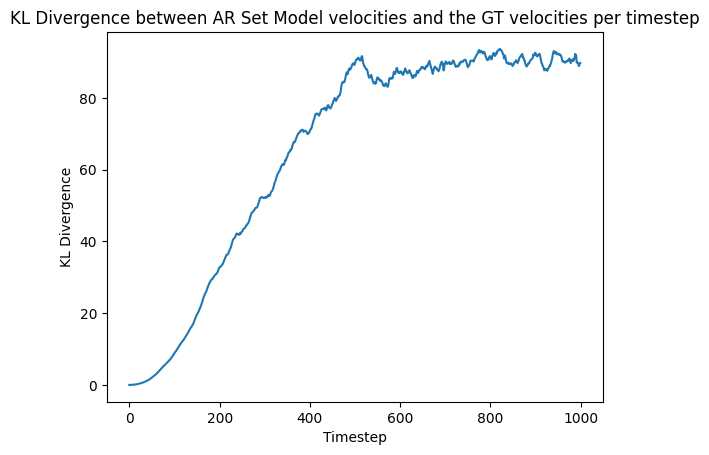

In [124]:
validation_files = [pfn for pfn in os.listdir("../../data/boids/raw/") if (16 <= int(pfn.split("_")[-1][:-4]) < 25)]
validation_trajectories = [np.load("../../data/boids/raw/" + f) for f in validation_files]
validation_trajectories = torch.tensor(validation_trajectories, dtype=torch.float)

dists_GT = compute_distribution_per_timestep(validation_trajectories[:,:,:,2:], 1000)
dists_AR_set = compute_distribution_per_timestep(ar_set_model_rollout[:,:,:,2:], 1000)

plot_kl_divergence(dists_AR_set, dists_GT, title="KL Divergence between AR Set Model velocities and the GT velocities per timestep")



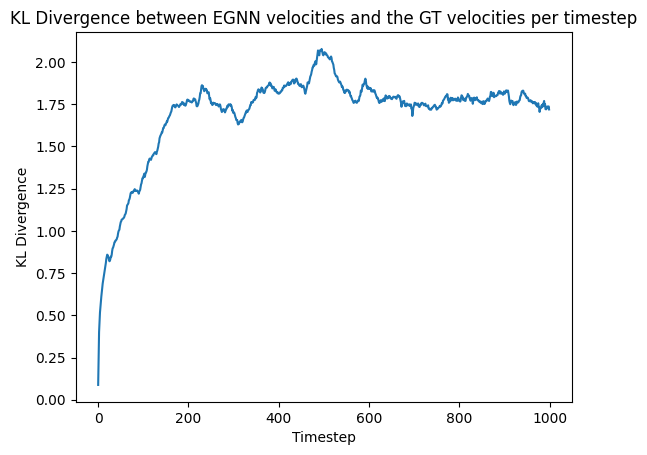

In [126]:
dists_equivariant = compute_distribution_per_timestep(translational_equivariant_model_rollout, 1000)
plot_kl_divergence(dists_equivariant, dists_GT, title="KL Divergence between EGNN velocities and the GT velocities per timestep")

# References

[1] Minartz, K., Poels, Y., Koop, S., & Menkovski, V. (2023). Equivariant Neural Simulators for Stochastic Spatiotemporal Dynamics. https://openreview.net/forum?id=CCVsGbhFdj

[2] Reynolds, C. W. (1987) Flocks, Herds, and Schools: A Distributed Behavioral Model, in Computer Graphics, 21(4) (SIGGRAPH '87 Conference Proceedings) pages 25-34.

[3] Satorras, V. G., Hoogeboom, E., & Welling, M. (2021, July). E (n) equivariant graph neural networks. In International conference on machine learning (pp. 9323-9332). PMLR.